# Coursework C

SN: 21019919

This document presents a comprehensive examination of autoencoders, focusing on their architectural design, practical implementation, and varied applications in advanced computational tasks. The content is structured to facilitate an in-depth understanding of autoencoders.

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam  # Use legacy optimiser for M1/M2 Macs as jupyter told me to


In [2]:
# Ryan's code below for use, haven't added docstrings as have just copied across:

#A big messy function to do the training
# model -- our keras neural model autoencoder
# image_generator -- a function to generate random images for the training (see below for examples)
# img_size -- the size of our image in pixels
# batchsize -- the number of images to include in each training batch
# steps -- the number of steps taken in the training
#
# returns an array of the costs

def generate_and_train(model,image_generator,img_size,batchsize,steps):
   
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    #y_test=np.zeros([1,pixels,pixels,1])
    #y_test[:,:,:,0]=image_generator(1,x,y)
    
    #Now create the empty arrays for the images and cost
    y_in=np.zeros([batchsize,img_size,img_size,1])
    y_target=np.zeros([batchsize,img_size,img_size,1])
    cost=np.zeros(steps)
    
    #Loop through the steps, get a random batch of samples, train the model, repeat
    for k in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        cost[k]=model.train_on_batch(y_in,y_target)
    
    return cost,y_target

def get_test_image(image_generator,img_size):
    #Generate an array of the numbers 1 to img_size and create a meshgrid from them    
    pixels=np.linspace(-1,1,img_size)
    x,y=np.meshgrid(pixels,pixels)
    
    #Now create a test image using 1 call to image_generator
    y_test=np.zeros([1,img_size,img_size,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    return y_test

# A function to generate and plot a single test image and the output of our model
# only to be called after training the model
def plot_test_image(model,image_generator,img_size):
    #Get random test image
    y_test=get_test_image(image_generator,img_size)
    
    #Create the output image
    y_test_out=model.predict_on_batch(y_test)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(y_test[0,:,:,0],origin='lower')
    ax[0].set_title("Input")
    ax[1].imshow(y_test_out[0,:,:,0],origin='lower')
    ax[1].set_title("Output")
    

        
def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features = get_layer_activations(network, y_in)
    for idx, feature in enumerate(layer_features):
        s = np.shape(feature)
        if len(s) == 4:  # Convolutional layer format
            print(f"Layer {idx}: {s[1] * s[2] * s[3]} neurons / {s}")
        elif len(s) == 2:  # Dense layer format
            print(f"Layer {idx}: {s[1]} neurons / {s}")
        else:
            print(f"Layer {idx}: Unknown layer shape {s}")
        
        
        
        
        
        
def get_layer_activation_extractor(network):
    #print(network.inputs)
    #for layer in network.layers:
    #    print(layer.output)
    return(keras.Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    #print(extractor)
    layer_features = extractor(y_in)
    return layer_features
    
    
    
    
# A simple image generator that returns an array of batchsize images
# each image has a size of x * y pixels
# in this image each image has a randomly placed circle (and the circle is of random size)
def circle_generator(batchsize,x,y):
    R=np.random.uniform(size=batchsize)
    x0=np.random.uniform(size=batchsize,low=-1,high=1)
    y0=np.random.uniform(size=batchsize,low=-1,high=1)
    return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )


# Task 1: Neural network design with 9 neurons implemented:

In this section, we define the architecture of the autoencoder for Task 1. The key feature of this model is the bottleneck layer, which contains no more than 9 neurons. This constraint is set to test the model's ability to encode and decode the input with limited information.

In [3]:
def autoencoder_model_9_neurons():
    '''Creates an autoencoder for 27x27 pixel images with a 9-neuron bottleneck layer.

    The autoencoder architecture includes:
    - Input Layer for images of shape (27, 27, 1)
    - Flatten Layer
    - Dense Layers with ReLU activation (64 neurons, bottleneck of 9 neurons, 64 neurons)
    - Output Dense Layer with sigmoid activation, reshaped to original image size

    Returns:
        A Keras Model instance of the autoencoder.
    '''
    input_shape = (27, 27, 1)
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(64, activation='relu')(x)
    bottleneck = Dense(9, activation='relu')(x)
    x = Dense(64, activation='relu')(bottleneck)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = Reshape(input_shape)(x)
    return Model(inputs=input_layer, outputs=output_layer)






autoencoder_9 = autoencoder_model_9_neurons()

# I have changed the learning rate from default of 0.001 to 0.0005, this allows for the cost to be below 0.02
autoencoder_9.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')


## Training the network
Here, we train the autoencoder using the randomly generated circle images. We adhere to the brief's requirement of using no more than 30,000 samples in total. This section details the batch size, number of training steps, and the use of the mean_squared_error loss function.


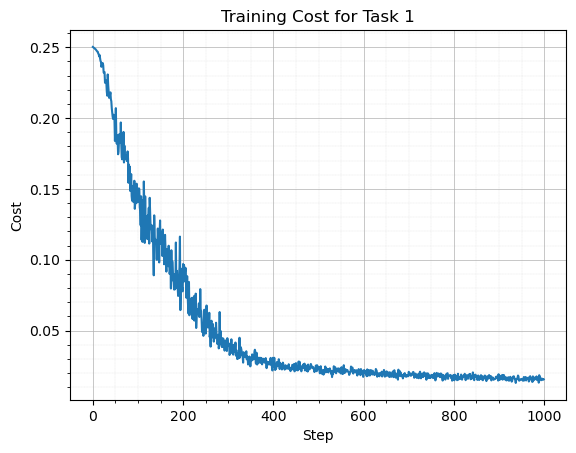

Final cost after training: 0.015568593516945839


In [4]:
# Training parameters as specified in brief
img_size = 27
batch_size = 30
steps = 1000

# Train the model using the provided function
cost_9, y_target_9 = generate_and_train(autoencoder_9, circle_generator, img_size, batch_size, steps)

# Plotting the training cost so we can visually see the training
plt.plot(cost_9)
plt.title('Training Cost for Task 1')
plt.xlabel('Step')
plt.ylabel('Cost')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.show()

# Print the final cost
final_cost = cost_9[-1]  # Accessing the last element of the cost array
print(f'Final cost after training: {final_cost}')

# Task 2: Neural network design but with 3 neurons implemented
This section is the same as in Task 1 but here we're using three neurons. This comprimises the quality so therefore the target cost should be increased from 0.02 to 0.06 as we're using less neurons (factor of three). 

In [5]:
def autoencoder_model_3_neurons():
    '''Constructs an autoencoder for 27x27 pixel images, but with a 3-neuron bottleneck.

    The autoencoder architecture includes:
    - Input Layer for images of shape (27, 27, 1)
    - Flatten Layer
    - Dense Layers with ReLU activation (64 neurons, bottleneck of 3 neurons, 64 neurons)
    - Output Dense Layer with sigmoid activation, reshaped to original image size

    Returns:
        A Keras Model instance of the autoencoder.
    '''
    input_shape = (27, 27, 1)
    input_layer = Input(shape=input_shape)
    x = Flatten()(input_layer)
    x = Dense(64, activation='relu')(x)
    bottleneck = Dense(3, activation='relu')(x)
    x = Dense(64, activation='relu')(bottleneck)
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    output_layer = Reshape(input_shape)(x)
    return Model(inputs=input_layer, outputs=output_layer)

autoencoder_3 = autoencoder_model_3_neurons()
autoencoder_3.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')


## Training the network again
Now, we train the autoencoder again using the randomly generated circle images but only with 3 neurons. We use the same requirements again.

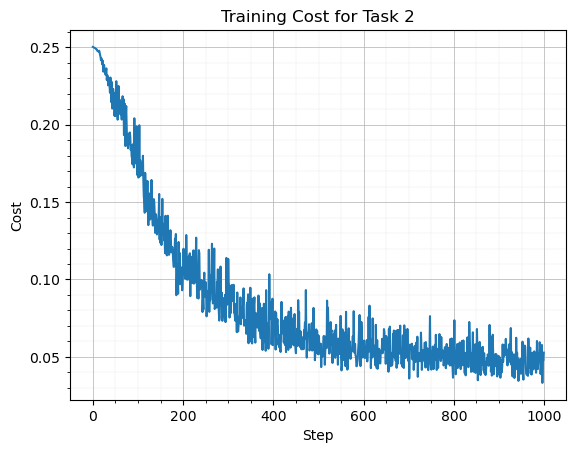

Final cost after training: 0.052769724279642105


In [6]:
# Using Ryan's generate_and_train function.
cost_3, y_target_3 = generate_and_train(autoencoder_3, circle_generator, img_size, batch_size, steps)

# Plotting the training cost for visualisation
plt.plot(cost_3)
plt.title('Training Cost for Task 2')
plt.xlabel('Step')
plt.ylabel('Cost')
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2')
plt.show()


# Print the final cost
final_cost = cost_3[-1]  # Accessing the last element of the cost array
print(f'Final cost after training: {final_cost}')

## Plotting the image for 9 Neuron CNN

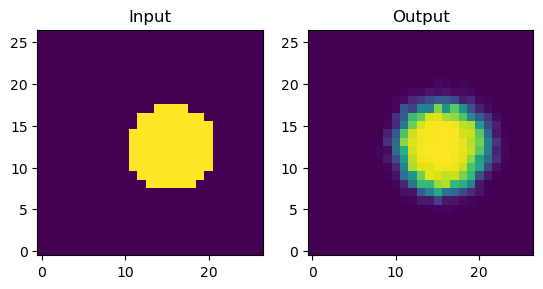

In [7]:
plot_test_image(autoencoder_9, circle_generator, img_size)


## Plotting the image for 3 Neuron CNN

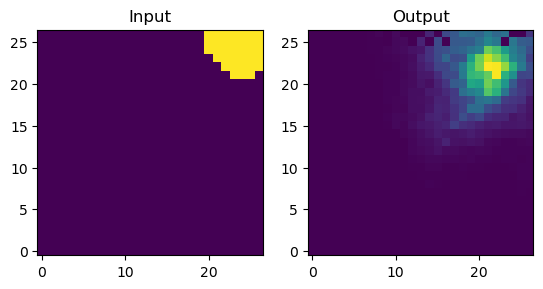

In [8]:
plot_test_image(autoencoder_3, circle_generator, img_size)


In [9]:
print_layers(autoencoder_9, get_test_image(circle_generator, img_size))

Layer 0: 729 neurons / (1, 27, 27, 1)
Layer 1: 729 neurons / (1, 729)
Layer 2: 64 neurons / (1, 64)
Layer 3: 9 neurons / (1, 9)
Layer 4: 64 neurons / (1, 64)
Layer 5: 729 neurons / (1, 729)
Layer 6: 729 neurons / (1, 27, 27, 1)


In [10]:
print_layers(autoencoder_3, get_test_image(circle_generator, img_size))

Layer 0: 729 neurons / (1, 27, 27, 1)
Layer 1: 729 neurons / (1, 729)
Layer 2: 64 neurons / (1, 64)
Layer 3: 3 neurons / (1, 3)
Layer 4: 64 neurons / (1, 64)
Layer 5: 729 neurons / (1, 729)
Layer 6: 729 neurons / (1, 27, 27, 1)


# Conclusion

In autoencoder models, bottlenecking refers to compressing the input data into a more compact representation at the bottleneck layer. The size of this bottleneck is key in balancing model performance and complexity.

Using larger bottleneck sizes allows the model to retain more complex features and nuances from the input data, facilitating more accurate reconstruction of the original data. This results in finer details in the reconstructed images and lower reconstruction errors. However, larger bottleneck sizes also mean more complex models with an increased number of parameters, requiring more computational power and time for training. This can lead to prolonged training durations and a heightened risk of overfitting.

In our analysis, we assess performance by observing the loss, noting that a lower loss at higher bottleneck values suggests a better replication of the original data by the autoencoder.

On the other hand, smaller bottleneck sizes simplify and condense the encoding of input data, reducing the dimensionality. While this can speed up training and result in less complex models, it may also lead to a loss of important information and subpar reconstruction quality, especially if the model fails to capture essential features of the input data. Moreover, smaller bottlenecks might struggle to accurately represent complex patterns and structures in the data therfore losing accuracy. 

To summarise, choosing the right bottleneck size involves a trade-off between simplicity and efficiency versus the quality of reconstruction and information preservation. While smaller bottlenecks offer efficiency but might compromise on the accuracy of reconstruction, larger bottlenecks improve reconstruction quality at the cost of increased complexity and the need for computing power. Finding the optimal bottleneck size often requires experimentation and balancing the specific needs of the project with computational constraints and performance goals.